# Korea


In [4]:
using Plots, CSV, DataFrames, Optim, Statistics, LinearAlgebra, Random, Dates, XLSX

In [5]:
# step 01 extract surprise

data = CSV.read("surprise.csv", DataFrame)
T, ~ = size(data)

# coupon rate
C1 = 8;              # coupon rate ~2010.9
C2 = 5;              # coupon rate 2010.10~
V = 100;             # face value
change_time = 28;    # row number of 2010.10

# implied rate
Rate=zeros(T,2);
for j in 1:2
    for t in 1:T
        F = data[t, 4+j]
        if t < change_time
            objective_function = R -> (F - (C1/2)/(1+R/2) - (C1/2)/((1+R/2)^2) - (C1/2)/((1+R/2)^3) - (C1/2)/((1+R/2)^4) - (C1/2)/((1+R/2)^5) - ((C1/2)+V)/((1+R/2)^6))^2
        else
            objective_function = R -> (F - (C2/2)/(1+R/2) - (C2/2)/((1+R/2)^2) - (C2/2)/((1+R/2)^3) - (C2/2)/((1+R/2)^4) - (C2/2)/((1+R/2)^5) - ((C2/2)+V)/((1+R/2)^6))^2
        end
        
        result = optimize(objective_function, 0.0, 0.1)
        Rate[t, j] = Optim.minimizer(result) * 100  # percentage
    end
end

# MP surprise, stock prise surprise
MPS = Rate[:,2].-Rate[:,1];
SPS = (data[:,8]./data[:,7].-1)*100;

In [6]:
# step 02 sign restriction

S = [MPS.-mean(MPS) SPS.-mean(SPS)]
~, K = size(S)
Sigma = S'*S
# cholesky
A = cholesky(Sigma).L

# P 행렬 만들기 (0, 2π)
N = 5000
LB = 0
UB = 2 * π
Random.seed!(20230812)
omega_vec = rand(N,1)
A_candidate = zeros(K, K, N)
e_candidate = zeros(T, K, N)
count = 1

# P 계산 후 검증
while count<N
    omega = LB + (UB - LB) * rand()
    P_candidate = [cos(omega) -sin(omega);
                   sin(omega)  cos(omega)]
    A_tilde = A * P_candidate
    if A_tilde[1,1] > 0 && A_tilde[2,1] < 0 && A_tilde[1,2] > 0 && A_tilde[2,2] > 0
        A_candidate[:, :, count] = A_tilde
        for t in 1:T
            e_candidate[:, :, count] = (A_tilde \ S')'
        end
        count += 1
    end
end

e_pc_seq = e_candidate[:, 1, :]
e_nc_seq = e_candidate[:, 2, :]

# mean
e_pc = mean(e_pc_seq,dims=2);
e_nc = mean(e_nc_seq,dims=2);

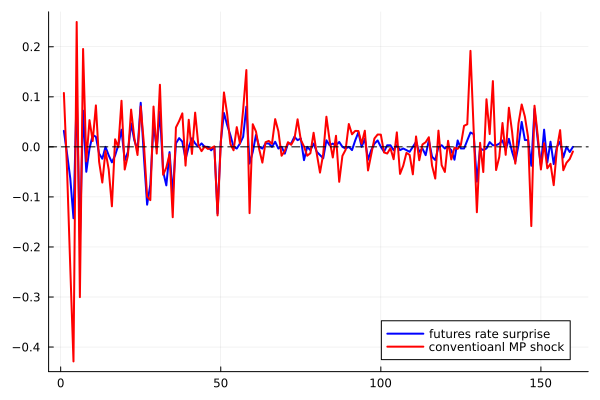

In [7]:
# 그래프

F1 = plot(MPS, color=:blue, lw=2, label="futures rate surprise")
plot!(F1, e_pc, color=:red, lw=2, label="conventioanl MP shock")
hline!(F1,[0], color=:black, linestyle=:dash, label="")

In [8]:
# step 03 monthly

data2 = DataFrame(Date = data.time, MPS = vec(MPS), SPS = vec(SPS), e_pc = vec(e_pc), e_nc = vec(e_nc))
# 연도와 월 추출
data2.MonthYear = Dates.yearmonth.(data2.Date)
# 같은 달의 값 합치기
monthly = combine(groupby(data2, :MonthYear), 
    :MPS => sum => :MPS,
    :SPS => sum => :SPS,
    :e_pc => sum => :e_pc,
    :e_nc => sum => :e_nc)

# 모든 월별 조합 생성
start_date = Date(2008, 8)
end_date = Date(2024, 2)
all_dates = Dates.yearmonth.(collect(Date(start_date):Month(1):Date(end_date)))

# 매칭하여 붙이기
all_dates_data = zeros(length(all_dates),4)
for (idx, row) in enumerate(all_dates)
    # 원래 데이터 셋에서의 위치 찾기
    row_index = findfirst(isequal(row), monthly.MonthYear)
    if row_index != nothing
        all_dates_data[idx,1]=data2[row_index,2]
        all_dates_data[idx,2]=data2[row_index,3]
        all_dates_data[idx,3]=data2[row_index,4]
        all_dates_data[idx,4]=data2[row_index,5]
    else
        all_dates_data[idx,:].=0
    end 
end

# 최종 월별 충격 시계열
monthly_shock = DataFrame(Month = all_dates,
    MPS = all_dates_data[:,1], 
    SPS = all_dates_data[:,2], 
    e_pc = all_dates_data[:,3], 
    e_nc = all_dates_data[:,4] );

# cut 2010.1월 이전
monthly_shock=monthly_shock[18:end,:];

In [9]:
# step 04 Local projection

macro_data = CSV.read("macro.csv", DataFrame)
macro_data.EMP = Float64.(macro_data.EMP)  # EMP int->Float
macro_data.nominalHP = macro_data[:,5]
macro_data[:,5] = macro_data[:,5]./macro_data[:,2]

# Note: macro(2006m1~2024m2)   MPS(2008m8~2024m2)
Num_shock = length(monthly_shock.Month)

H = 40 # horizon
M = 12 # lag of AR
I = 12  # lag of shock variables
N = Num_shock-H # N =end point index of shock series
precut = 17    # push to 2010m1
start_idx = 32  #2008m8  in macro series


# shock variables
S = monthly_shock.e_pc[1+I:N]
S_lag = zeros(length(S),I)
if I!=0
    Threads.@threads for i=1:I
        S_lag[:,i]= monthly_shock.e_pc[1+I-i:N-i]
    end
end


# for each macro variable
K = 6
beta_h = zeros(H+1,K)
std_h = zeros(H+1,K)

Threads.@threads for k=1:K
    Y = log.(macro_data[:,k+1])
    # (N-I) = sample size for the each regression
    Y_lag = zeros(N-I,M)
    for m=1:M
        Y_lag[:,m]=Y[start_idx+I-1:N+(start_idx-1)-1] - Y[start_idx+I-1-m:N+(start_idx-1)-1-m]
    end
    if I!=0
        X = [S S_lag Y_lag ones(N-I,1)]
    else
        X = [S Y_lag ones(N-I,1)]
    end
    sample_num, explain_num = size(X)
    df = sample_num-explain_num
    
    Threads.@threads for h=0:H
        
        # regression
        dep = Y[1+(start_idx+I-1)+h:N+(start_idx-1)+h] - Y[start_idx+I-1:N+(start_idx-1)-1]
        beta = (X'*X) \ (X'*dep)
        e = dep - X*beta
        
        # White Heteroskadasticity Consistent estimator (Olea & Plagborg-Moller(2021))
        X_Omega0_X = (sample_num/df).*X'*Diagonal(e.^2)*X;
        Var_beta=(X' * X) \ X_Omega0_X / (X' * X)
        
        # save
        beta_h[h+1,k] = beta[1]
        std_h[h+1,k] = sqrt(Var_beta[1,1])
    end
end

# 추정의 정보
println("Start                            : ", monthly_shock.Month[1+I])
println("End                              : ", monthly_shock.Month[N])
println("sample number of each regression : ", N-I)
println("horizon (month)                  : ", H)

Start                            : (2011, 1)
End                              : (2020, 10)
sample number of each regression : 118
horizon (month)                  : 40


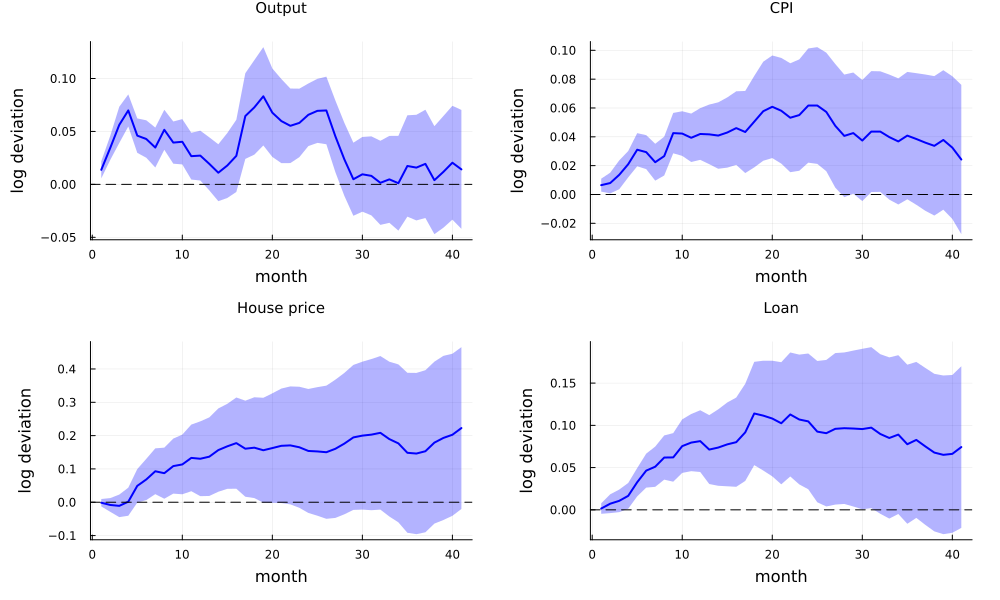

In [10]:
# plot
horizon = range(1,H+1,H+1)

labels = ["Output", "CPI", "Employment", "House price", "CD rate", "Loan"]
figures= []
lower = -beta_h.-std_h
upper = -beta_h.+std_h

for i in [1, 2, 4, 6]
    F = plot(-beta_h[:, i], ribbon=(std_h[:,i], std_h[:,i]), fillalpha=0.3, color=:blue, xlabel="month", ylabel="log deviation", title=labels[i], label="", lw=2, titlefontsize=10)
    hline!(F, [0], label="", lw=1, linecolor=:black, linestyle=:dash)
    push!(figures, F)
end

# 모든 그래프를 하나의 레이아웃에 표시
plot(figures..., layout=(2, 2), size=(1000, 600), margin=20Plots.px)
# savefig("macro_Korea.png")

In [11]:
# step 05 zip code level house prices

@time begin
    
zip_HP= XLSX.readdata("REPS_Si_Gun_Gu.xlsx", "data", "B5:IM222")
level_dum= XLSX.readdata("REPS_Si_Gun_Gu.xlsx", "level", "A2:D247")
level = level_dum[:,1]
Seoul_metro = level_dum[:,2]
Busan_metro = level_dum[:,3]
Daegu_metro = level_dum[:,4]
    
~, K = size(zip_HP)

# for each macro variable
beta_hp = zeros(H+1,K)

Threads.@threads for k=1:K
    Y = log.(zip_HP[:,k])
    # (N-I) = sample size for the each regression
    Y_lag = zeros(N-I,M)
    for m=1:M
        Y_lag[:,m]=Y[start_idx+I-1:N+(start_idx-1)-1] - Y[start_idx+I-1-m:N+(start_idx-1)-1-m]
    end
    if I!=0
        X = [S S_lag Y_lag ones(N-I,1)]
    else
        X = [S Y_lag ones(N-I,1)]
    end
    sample_num, explain_num = size(X)
    df = sample_num-explain_num
    
    Threads.@threads for h=0:H
        
        # regression
        dep = Y[1+(start_idx+I-1)+h:N+(start_idx-1)+h] - Y[start_idx+I-1:N+(start_idx-1)-1]
        beta = (X'*X) \ (X'*dep)
        
        # White Heteroskadasticity Consistent estimator (Olea & Plagborg-Moller(2021))
        # e = dep - X*beta
        # X_Omega0_X = (sample_num/df).*X'*Diagonal(e.^2)*X;
        # Var_beta=(X' * X) \ X_Omega0_X / (X' * X)
        
        # save
        beta_hp[h+1,k] = beta[1]
        # std_h[h+1,K] = sqrt(Var_beta[1,1])
    end
end

# 추정의 정보
println("Start                            : ", monthly_shock.Month[1+I])
println("End                              : ", monthly_shock.Month[N])
println("sample number of each regression : ", N-I)
println("horizon (month)                  : ", H)

end

Start                            : (2011, 1)
End                              : (2020, 10)
sample number of each regression : 118
horizon (month)                  : 40
  5.452618 seconds (4.66 M allocations: 435.285 MiB, 10.12% gc time, 84.27% compilation time)


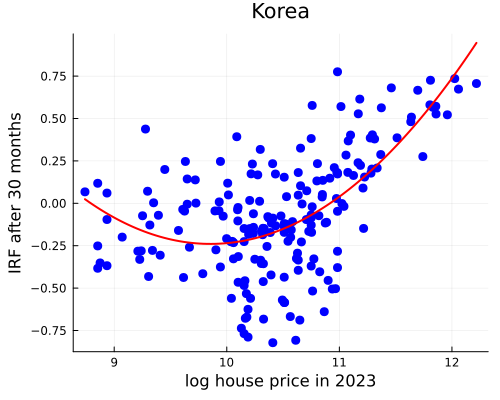

In [12]:
# Figure
no_missing_lv = []
no_missing_beta = []
S_dum = []
B_dum = []
D_dum = []

for i = 1:length(level)
    if !ismissing(level[i]) && level[i]>8 # kill the outlier and missing
        push!(no_missing_lv, level[i])
        push!(no_missing_beta, -beta_hp[31, i])       
        push!(S_dum, Seoul_metro[i])
        push!(B_dum, Busan_metro[i])
        push!(D_dum, Daegu_metro[i])
    end
end

# quadratic regression line
reg_X = [ones(length(no_missing_lv),1) no_missing_lv no_missing_lv.^2]
# conver {Any} to {Float64}
reg_X = convert(Matrix{Float64}, reg_X)
no_missing_beta = reshape(no_missing_beta,length(no_missing_beta),1)
no_missing_beta = convert(Matrix{Float64},no_missing_beta)
beta = (reg_X'*reg_X) \ (reg_X'*no_missing_beta)
Num_p = 100
x_dom = range(minimum(no_missing_lv),maximum(no_missing_lv), Num_p)
X_dom =[ones(Num_p,1) x_dom x_dom.^2]
y_fit = X_dom*beta


F1 = scatter(no_missing_lv, no_missing_beta, xlabel="log house price in 2023", ylabel="IRF after 30 months",label="", title="Korea", markerstrokewidth=0, markersize=5, markercolor=:blue)
plot!(F1, x_dom, y_fit, color=:red, lw=2, label="", size=(500,400))
savefig("Korea.png")
display(F1)

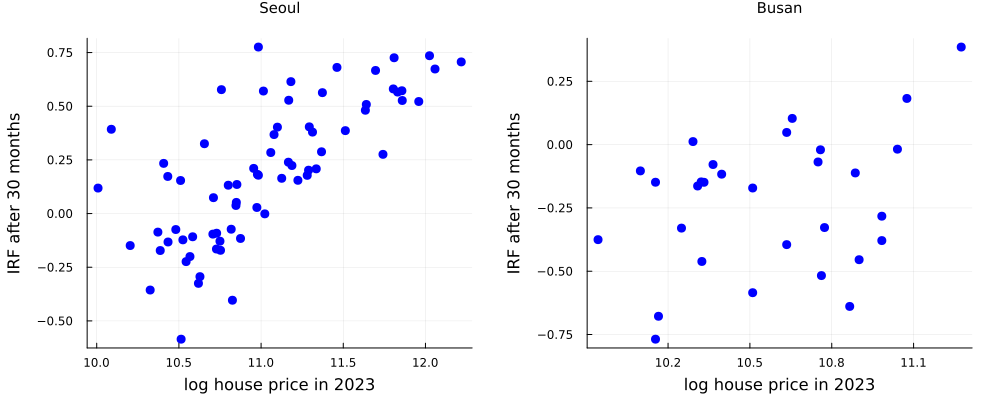

In [13]:
S_idx = findall(x -> x == 1, S_dum)
B_idx = findall(x -> x == 1, B_dum)
S_lv = no_missing_lv[S_idx]
B_lv = no_missing_lv[B_idx]
S_beta = no_missing_beta[S_idx]
B_beta = no_missing_beta[B_idx]

scatter(S_lv, S_beta)

F2 = scatter(S_lv, S_beta, xlabel="log house price in 2023", ylabel="IRF after 30 months",title="Seoul",label="", titlefontsize=10, markerstrokewidth=0, markersize=5, markercolor=:blue)
F3 = scatter(B_lv, B_beta, xlabel="log house price in 2023", ylabel="IRF after 30 months",title="Busan",label="", titlefontsize=10, markerstrokewidth=0, markersize=5, markercolor=:blue)

plot(F2, F3, layout=(1, 2), size=(1000, 400), margin=20Plots.px)
# savefig("Seoul_Busan.png")

# Asymetry


In [14]:
# step 06 asymetry


# shock variables
S = monthly_shock.e_pc[1+I:N]
S_EMP = monthly_shock.e_pc[1+I:N].*(S.<0)
S_CMP = monthly_shock.e_pc[1+I:N].*(S.>0)
S_lag = zeros(length(S),I)
if I!=0
    Threads.@threads for i=1:I
        S_lag[:,i]= monthly_shock.e_pc[1+I-i:N-i]
    end
end


@time begin
    
zip_HP= XLSX.readdata("REPS_Si_Gun_Gu.xlsx", "data", "B5:IM222")
level_dum= XLSX.readdata("REPS_Si_Gun_Gu.xlsx", "level", "A2:D247")
level = level_dum[:,1]
Seoul_metro = level_dum[:,2]
Busan_metro = level_dum[:,3]
Daegu_metro = level_dum[:,4]
    
~, K = size(zip_HP)

# for each macro variable
beta_emp_hp = zeros(H+1,K)
beta_cmp_hp = zeros(H+1,K)

Threads.@threads for k=1:K
    Y = log.(zip_HP[:,k])
    # (N-I) = sample size for the each regression
    Y_lag = zeros(N-I,M)
    for m=1:M
        Y_lag[:,m]=Y[start_idx+I-1:N+(start_idx-1)-1] - Y[start_idx+I-1-m:N+(start_idx-1)-1-m]
    end
    if I!=0
        X = [S_EMP S_CMP S_lag Y_lag ones(N-I,1)]
    else
        X = [S_EMP S_CMP Y_lag ones(N-I,1)]
    end
    sample_num, explain_num = size(X)
    df = sample_num-explain_num
    
    Threads.@threads for h=0:H
        
        # regression
        dep = Y[1+(start_idx+I-1)+h:N+(start_idx-1)+h] - Y[start_idx+I-1:N+(start_idx-1)-1]
        beta = (X'*X) \ (X'*dep)
        
        # White Heteroskadasticity Consistent estimator (Olea & Plagborg-Moller(2021))
        # e = dep - X*beta
        # X_Omega0_X = (sample_num/df).*X'*Diagonal(e.^2)*X;
        # Var_beta=(X' * X) \ X_Omega0_X / (X' * X)
        
        # save
        beta_emp_hp[h+1,k] = beta[1]
        beta_cmp_hp[h+1,k] = beta[2]
        # std_h[h+1,K] = sqrt(Var_beta[1,1])
    end
end

# 추정의 정보
println("Start                            : ", monthly_shock.Month[1+I])
println("End                              : ", monthly_shock.Month[N])
println("sample number of each regression : ", N-I)
println("horizon (month)                  : ", H)

end

Start                            : (2011, 1)
End                              : (2020, 10)
sample number of each regression : 118
horizon (month)                  : 40
  1.063470 seconds (1.26 M allocations: 212.506 MiB, 42.45% gc time, 17.31% compilation time)


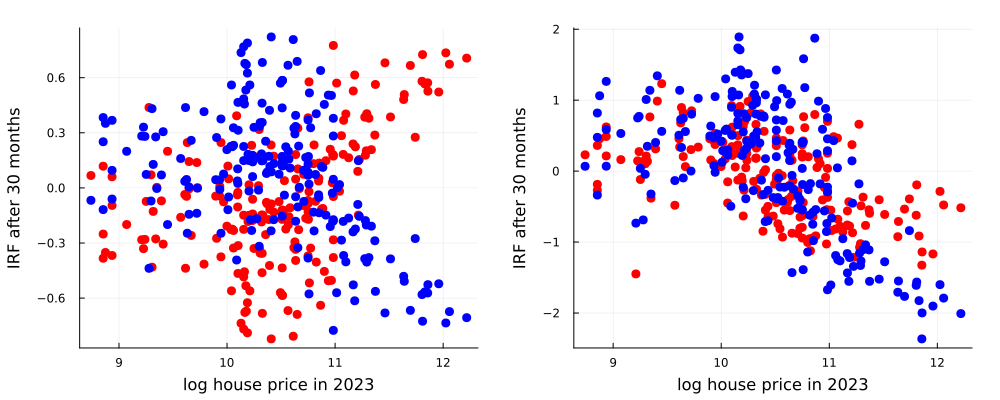

In [16]:
# Figure
no_missing_lv = []
no_missing_beta_emp = []
no_missing_beta_cmp = []

for i = 1:length(level)
    if !ismissing(level[i]) && level[i]>8 # kill the outlier and missing
        push!(no_missing_lv, level[i])
        push!(no_missing_beta_emp, -beta_emp_hp[31, i])
        push!(no_missing_beta_cmp, beta_cmp_hp[31, i]) 
    end
end


as1 = scatter(no_missing_lv, no_missing_beta, xlabel="log house price in 2023", ylabel="IRF after 30 months",label="", markerstrokewidth=0, markersize=5, markercolor=:red)
scatter!(as1, no_missing_lv, -no_missing_beta, label="", markerstrokewidth=0, markersize=5, markercolor=:blue)

as2 = scatter(no_missing_lv, no_missing_beta_emp, xlabel="log house price in 2023", ylabel="IRF after 30 months",label="", markerstrokewidth=0, markersize=5, markercolor=:red)
scatter!(as2, no_missing_lv, no_missing_beta_cmp, label="", markerstrokewidth=0, markersize=5, markercolor=:blue)

plot(as1, as2, layout=(1, 2), size=(1000, 400), margin=20Plots.px)